### 주제: 뉴스 토픽 분류 (한국어)
---
- 출처: https://dacon.io/competitions/official/235747/overview/description

In [2]:
# 모듈 로딩
import pandas as pd
import platform
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow import random # random seed 설정용
from sklearn.model_selection import StratifiedKFold

[1] 데이터 준비

In [3]:
# 데이터 로딩
topicDf = pd.read_csv('train_data.csv').iloc[:,1:]
topicDict = pd.read_csv('topic_dict.csv')

In [4]:
topicDf.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [5]:
# 결측치 체크
topicDf.isnull().sum()

title        0
topic_idx    0
dtype: int64

In [6]:
# 중복 데이터 체크
topicDf.duplicated().sum()

0

In [7]:
topicDict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [8]:
topic_count = pd.DataFrame(topicDf.topic_idx.value_counts().sort_index())
topic_count['topic'] = topicDict.topic
topic_count

,topic_idx,topic
0,4824,IT과학
1,6222,경제
2,7362,사회
3,5933,생활문화
4,7629,세계
5,6933,스포츠
6,6751,정치


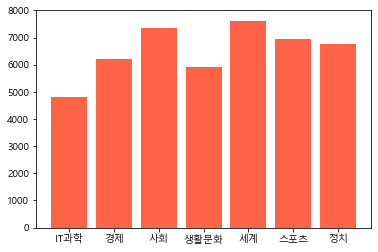

In [9]:
# topic label 분포도
if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
else:
    plt.rc('font',family='AppleGothic')
        
plt.bar(topic_count.topic, topic_count.topic_idx, color='tomato')
plt.show()

[2] 데이터 처리

In [10]:
# 형태소 분리 객체
okt = Okt()

In [11]:
# 형태소 분리 후 태깅하는 함수
def makeTagging(data):
    result_list = []
    for title in data:
        result = []
        for word in okt.pos(title, stem=True): # 어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: # 'Noun'-명사, 'Verb'-동사, 'Adjective'-형용사 
                if(len(word[0])>1): # 한 글자 단어들 빼줌
                    result.append(word[0])
        result_list.append(result)
    return result_list

In [12]:
result_list = makeTagging(topicDf.title)

In [13]:
# 데이터 확인
for i in range(5):
    print(result_list[i])

['인천', '핀란드', '항공기', '결항', '휴가', '여행객', '분통']
['실리콘밸리', '넘어서다', '구글', '들이다', '전역', '거점']
['이란', '외무', '긴장', '완화', '해결', '미국', '경제', '전쟁', '멈추다']
['클린턴', '측근', '기업', '특수', '관계', '조명', '공과', '맞다', '물리다', '종합']
['시진핑', '트럼프', '중미', '무역', '협상', '조속', '타결', '희망']


In [14]:
# 분리한 단어들로 문장 다시 생성하는 함수
def makeData(data):
    total_list = []
    for stc in data:
        sentence = ''
        for word in stc:
            sentence=sentence+' '+word
        total_list.append(sentence.strip())
    return total_list

In [15]:
total_data = makeData(result_list)

In [16]:
topicDf['new_title'] = total_data

In [17]:
# 데이터 확인
for i in range(5):
    print(topicDf.new_title[i])

인천 핀란드 항공기 결항 휴가 여행객 분통
실리콘밸리 넘어서다 구글 들이다 전역 거점
이란 외무 긴장 완화 해결 미국 경제 전쟁 멈추다
클린턴 측근 기업 특수 관계 조명 공과 맞다 물리다 종합
시진핑 트럼프 중미 무역 협상 조속 타결 희망


In [131]:
# 비율에 맞게 학습/테스트 데이터 분활
X_train, X_test, y_train, y_test = train_test_split(topicDf.new_title, 
                                                    topicDf.topic_idx, 
                                                    test_size=0.2, 
                                                    stratify=topicDf.topic_idx,
                                                    random_state=11)

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.2, 
                                                  stratify=y_train,
                                                  random_state=11)

In [133]:
# 인덱스 초기화
X_train = X_train.reset_index().iloc[:,1]
X_test = X_test.reset_index().iloc[:,1]
X_val = X_val.reset_index().iloc[:,1]
y_train = y_train.reset_index().iloc[:,1]
y_test = y_test.reset_index().iloc[:,1]
y_val = y_val.reset_index().iloc[:,1]

In [134]:
print(f'X_train : {X_train.shape}, X_test : {X_test.shape} , X_val : {X_val.shape}')

X_train : (29218,), X_test : (9131,) , X_val : (7305,)


[3] 단어사전 생성

[3-1] 단어사전 생성 및 사용할 단어사전 수 설정

In [22]:
# 단어사전 생성하는 함수
def makeVoca(numWord=0):
    if numWord>0:
        myToken=Tokenizer(num_words=numWord)
    else:
        myToken=Tokenizer()
    
    # 단어사전(voca) 생성
    myToken.fit_on_texts(X_train)   
    return myToken

In [23]:
# 텍스트 데이터 토큰화 진행
myToken=makeVoca()
print('word index: {}'.format(len(myToken.word_index)))

word index: 21285


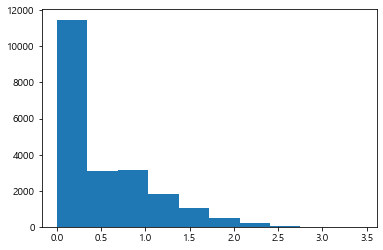

전체 토큰 수 : 21285
전체 토큰 빈도 수 : 206147
8500 위 까지 등장 토큰 빈도수 : 176998
비율 : 85.86009012985879


In [24]:
num_words = 8500
word_counts = dict(myToken.word_counts.items())
counts = list(word_counts.values())

plt.hist(np.log10(counts))
plt.show()
print('전체 토큰 수 :', len(counts))
print('전체 토큰 빈도 수 :',np.sum(counts))
print(num_words,'위 까지 등장 토큰 빈도수 :', np.sum(counts[:num_words]))
print('비율 :',np.sum(counts[:num_words])/np.sum(counts) *100 )

In [25]:
myToken=makeVoca(num_words)
print('word index: {}'.format(len(myToken.word_index)))

word index: 21285


[3-2] 텍스트 => 정수 수치화 (생성한 단어사전 기반)

In [135]:
seq_train=myToken.texts_to_sequences(X_train)
seq_test=myToken.texts_to_sequences(X_test)
seq_val=myToken.texts_to_sequences(X_val)

In [136]:
# 패딩 길이 설정 
def checkLength(datas):
    length = []
    for data in datas:
        length.append(len(data))
    plt.hist(length)
    plt.xlabel('length')
    plt.show()
    return length

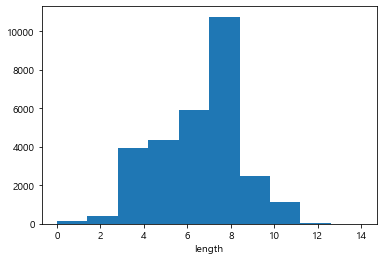

In [137]:
length=checkLength(seq_train)

In [138]:
pad_length = max(length)

In [139]:
train_seq = pad_sequences(seq_train, maxlen=pad_length)
test_seq = pad_sequences(seq_test, maxlen=pad_length)
val_seq = pad_sequences(seq_val, maxlen=pad_length)

In [140]:
train_seq.shape, test_seq.shape, val_seq.shape

((29218, 14), (9131, 14), (7305, 14))

[4] 모델 구성

방법 1. 심플RNN

---

In [122]:
random.set_seed(11)

In [123]:
model = Sequential()
model.add(Embedding(num_words, 32, input_length=pad_length))
model.add(Dropout(0.2))
model.add(SimpleRNN(64))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 14, 32)            272000    
                                                                 
 dropout_16 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                6208      
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 278,663
Trainable params: 278,663
Non-trainable params: 0
_________________________________________________________________


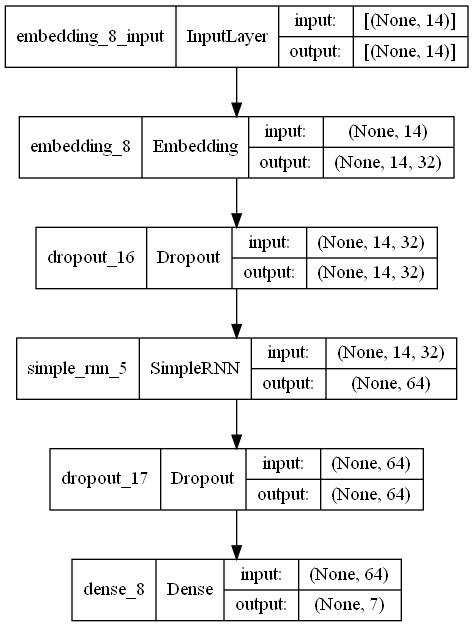

In [124]:
plot_model(model, show_shapes=True)

In [125]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [126]:
hist = model.fit(train_seq, y_train, 
                epochs=5, 
                batch_size=64, 
                validation_data=(val_seq, y_val))

Epoch 1/5
457/457 [==============================] - 4s 6ms/step - loss: 1.1845 - accuracy: 0.5552 - val_loss: 0.7254 - val_accuracy: 0.7608
Epoch 2/5
457/457 [==============================] - 2s 5ms/step - loss: 0.5634 - accuracy: 0.8196 - val_loss: 0.6407 - val_accuracy: 0.7836
Epoch 3/5
457/457 [==============================] - 2s 5ms/step - loss: 0.4138 - accuracy: 0.8674 - val_loss: 0.6943 - val_accuracy: 0.7752
Epoch 4/5
457/457 [==============================] - 2s 5ms/step - loss: 0.3283 - accuracy: 0.8954 - val_loss: 0.7050 - val_accuracy: 0.7830
Epoch 5/5
457/457 [==============================] - 2s 5ms/step - loss: 0.2646 - accuracy: 0.9141 - val_loss: 0.7686 - val_accuracy: 0.7828


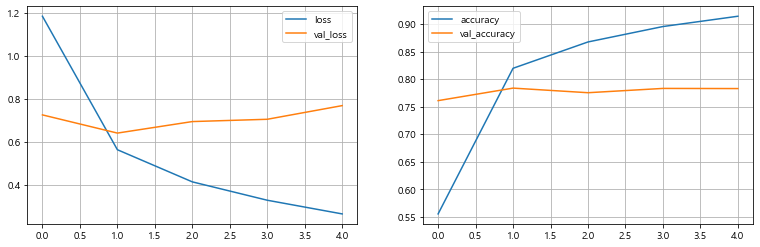

In [127]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.subplot(122)
plt.plot(hist.epoch, hist.history['accuracy'])
plt.plot(hist.epoch, hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [141]:
model.evaluate(test_seq, y_test)

286/286 [==============================] - 1s 2ms/step - loss: 0.7833 - accuracy: 0.7798


[0.7833303809165955, 0.7797612547874451]

방법 2. 양방향 LSTM

---

In [142]:
random.set_seed(11)

In [143]:
model2 = Sequential()
model2.add(Embedding(num_words, 32, input_length=pad_length))
model2.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model2.add(Dropout(0.3))
model2.add(Bidirectional(LSTM(units=32)))
model2.add(Dropout(0.3))
model2.add(Dense(7, activation='softmax'))

model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 14, 32)            272000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 14, 64)           16640     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 64)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 7)                

In [144]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [145]:
hist2 = model2.fit(train_seq, y_train, 
                epochs=5, 
                batch_size=64, 
                validation_data=(val_seq, y_val))

Epoch 1/5
457/457 [==============================] - 17s 22ms/step - loss: 1.0924 - accuracy: 0.5740 - val_loss: 0.6771 - val_accuracy: 0.7717
Epoch 2/5
457/457 [==============================] - 7s 15ms/step - loss: 0.5165 - accuracy: 0.8346 - val_loss: 0.6500 - val_accuracy: 0.7892
Epoch 3/5
457/457 [==============================] - 8s 17ms/step - loss: 0.3847 - accuracy: 0.8798 - val_loss: 0.6661 - val_accuracy: 0.7875
Epoch 4/5
457/457 [==============================] - 7s 16ms/step - loss: 0.3085 - accuracy: 0.9069 - val_loss: 0.7241 - val_accuracy: 0.7840
Epoch 5/5
457/457 [==============================] - 7s 15ms/step - loss: 0.2526 - accuracy: 0.9253 - val_loss: 0.7562 - val_accuracy: 0.7832


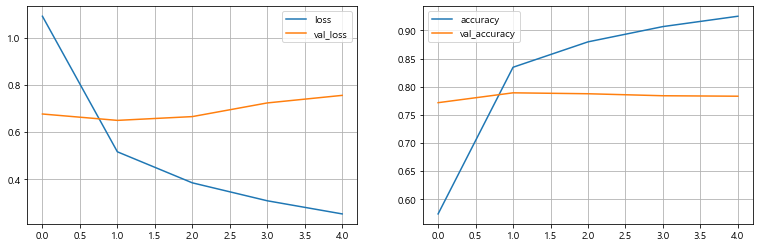

In [146]:
plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(hist2.epoch, hist2.history['loss'])
plt.plot(hist2.epoch, hist2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.subplot(122)
plt.plot(hist2.epoch, hist2.history['accuracy'])
plt.plot(hist2.epoch, hist2.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [148]:
model2.evaluate(test_seq, y_test)

286/286 [==============================] - 1s 5ms/step - loss: 0.7725 - accuracy: 0.7858


[0.7724987864494324, 0.7857846617698669]

test_data.csv로 예측

---

In [149]:
# 데이터 로딩
testDf = pd.read_csv('test_data.csv').iloc[:,1:]
sub = pd.read_csv('sample_submission.csv')

In [150]:
testDf

,title
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...
9126,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [152]:
test_list = makeTagging(testDf.title)

In [153]:
# 분리한 단어들로 문장 다시 생성하는 함수
def makeData(data):
    total_list = []
    for stc in data:
        sentence = ''
        for word in stc:
            sentence=sentence+' '+word
        total_list.append(sentence.strip())
    return total_list

In [154]:
total_test = makeData(test_list)

In [155]:
testDf['new_title'] = total_test

In [156]:
# 데이터 확인
for i in range(5):
    print(testDf.new_title[i])

유튜브 내달 크리에이터 지원 공간 운영
어버이날 맑다 흐려지다 남부 지방 옅다 황사
내년 국가 평가 논문 건수 반영 않다
김명자 신임 과총 회장 원로 젊다 과학자 지혜 모으다
회색 인간 작가 동식 양심 고백 소설 추다


In [157]:
seq_title=myToken.texts_to_sequences(testDf.new_title)

In [158]:
title_seq = pad_sequences(seq_title, maxlen=pad_length)

In [159]:
title_seq[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 1307,  132,
         20, 1566,  268])

In [160]:
title_seq[15]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,   26, 1486,
       2320,  158,    2])

In [166]:
q = []
for i in range(len(title_seq)):
    q.append(model2.predict([title_seq[[i]]]))

In [168]:
topic = []
for i in range(len(q)):
    topic.append(np.argmax(q[i]))

In [170]:
sub['topic_idx'] = topic

In [171]:
sub = sub.set_index(keys='index')

In [172]:
sub.to_csv('제출용1.csv')

---

In [189]:
random.set_seed(11)

In [190]:
model3 = Sequential()
model3.add(Embedding(num_words, 32, input_length=pad_length))
model3.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model3.add(Dropout(0.3))
model3.add(Bidirectional(LSTM(units=32)))
model3.add(Dropout(0.3))
model3.add(Dense(7, activation='softmax'))

model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 14, 32)            272000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 14, 64)           16640     
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 14, 64)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 64)               24832     
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 7)               

In [191]:
model3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [192]:
# 모델 체크포인트 생성
from keras.callbacks import ModelCheckpoint

path='./{epoch:02d}-{val_accuracy:.4f}.hdf5'
model_ckpt = ModelCheckpoint(path, save_best_only=True, monitor='val_accuracy')

In [193]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(train_seq, y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(train_seq[i_trn], 
            y_train[i_trn],
            validation_data=(train_seq[i_val], y_train[i_val]),
            epochs=10,
            batch_size=512,
            callbacks=[model_ckpt])

training model for CV #1
Epoch 1/10
46/46 [==============================] - 14s 154ms/step - loss: 1.8750 - accuracy: 0.2412 - val_loss: 1.5962 - val_accuracy: 0.3232
Epoch 2/10
46/46 [==============================] - 4s 84ms/step - loss: 1.1598 - accuracy: 0.5388 - val_loss: 0.9094 - val_accuracy: 0.6976
Epoch 3/10
46/46 [==============================] - 5s 106ms/step - loss: 0.7128 - accuracy: 0.7356 - val_loss: 0.7741 - val_accuracy: 0.7057
Epoch 4/10
46/46 [==============================] - 4s 84ms/step - loss: 0.5295 - accuracy: 0.8133 - val_loss: 0.7565 - val_accuracy: 0.7582
Epoch 5/10
46/46 [==============================] - 4s 84ms/step - loss: 0.3970 - accuracy: 0.8782 - val_loss: 0.7394 - val_accuracy: 0.7740
Epoch 6/10
46/46 [==============================] - 5s 107ms/step - loss: 0.3059 - accuracy: 0.9126 - val_loss: 0.7684 - val_accuracy: 0.7806
Epoch 7/10
46/46 [==============================] - 4s 81ms/step - loss: 0.2500 - accuracy: 0.9302 - val_loss: 0.8325 - val_a

In [207]:
# 모델 불러오기
from keras.models import load_model

model3=load_model('01-0.9624.hdf5')

In [208]:
model3.evaluate(test_seq, y_test)

286/286 [==============================] - 4s 7ms/step - loss: 0.7894 - accuracy: 0.7712


[0.7894023060798645, 0.7712188959121704]